In [8]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Get cpu, gpu or mps device for training.
device = (
    "cuda" 
    if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
path = 'data/new_excerpt.txt'
with open(path,'r') as fp:
    excerpt = fp.read()
excerpt = excerpt[:int(1e6)]
len(excerpt)

1000000

In [10]:
chars = set(excerpt)
chars = sorted(list(chars))
str_to_idx = {c:i for i,c in enumerate(chars)}
idx_to_str = {i:c for c,i in str_to_idx.items()}
vocab_size = len(str_to_idx)
vocab_size

82

In [11]:
encoded = torch.tensor(tuple(str_to_idx[ch] for ch in excerpt))

In [12]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
       
       Returns
       ---------
       x: (n_seqs,n_steps)
       
       y: (n_seqs,n_steps)
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = torch.zeros_like(x) # y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [13]:
def predict(model, char, h=None, top_k=None):
    ''' Given a character, predict the next character.
    
        Returns the predicted character and the hidden state.
    '''
    
    if h is None:
        h = model.init_hidden(1)
    
    x = [[str_to_idx[char]]]
    inputs = torch.tensor(x)
    inputs = inputs.to(device)

    
    h = tuple([each.data for each in h])
    out, h = model.forward(inputs, h)

    p = F.softmax(out, dim=1).data

    
    if top_k is None:
        top_ch = np.arange(vocab_size)
    else:
        p, top_ch = p.topk(top_k)
        top_ch = top_ch.cpu().numpy().squeeze()
    
    p = p.cpu().numpy().squeeze()
    char = np.random.choice(top_ch, p=p/p.sum())
    
    return idx_to_str[char], h

def sample(net, size, prime='The', top_k=None):
    net.eval()
    
    h = net.init_hidden(1)
    h = tuple(hn.to(device) for hn in h)
    
    chars = [ch for ch in prime]
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for _ in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [14]:
decoding = lambda x : "".join(idx_to_str[i.item()] for i in x)
X,y = next(get_batches(encoded,32,150))
print(X.shape, y.shape)
decoded_X = list(decoding(x) for x in X)
decoded_y = list(decoding(x) for x in y)
print(decoded_X[0:3])
print(decoded_y[0:3])

torch.Size([32, 150]) torch.Size([32, 150])
["Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again. Carly", 'cing Delays (AP) AP - A lunar orbiter that Japan had planned to launch this year could face further delays, possibly until next year or later, because', "  pioneer, have reached Thom Bay. Shuttle camera to watch fuel tank The space shuttle's external fuel tank, implicated in the 2003 Columbia disaster, "]
["all St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again. Carlyl", 'ing Delays (AP) AP - A lunar orbiter that Japan had planned to launch this year could face further delays, possibly until next year or later, because ', " pioneer, have reached Thom Bay. Shuttle camera to watch fuel tank The space shuttle's external fuel tank, implicated in the 2003 Columbia disaster, i"]


In [15]:
class Char_RNN_Model(nn.Module):
    def __init__(self,embed_sz,hidden_sz,num_layers,vocab_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_sz = hidden_sz
        self.embedding = nn.Embedding(vocab_size,embed_sz)
        self.rnn = nn.LSTM(
            input_size = embed_sz,
            hidden_size = hidden_sz,
            num_layers = num_layers,
            batch_first = True,
            dropout = 0.5,
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(hidden_sz,vocab_size)
    def forward(self, x, h=None):
        # x - (batch_sz,seq_len)
        x = self.embedding(x)
        # rnn(batch_sz,seq_len,input_sz)
        # -> x - (batch_sz,seq_len,hidden_sz),
        #    h - (n_layers,batch_sz,hidden_sz)
        x,h = self.rnn(x,h)
        x = x.reshape(-1,self.hidden_sz) # (batch_sz * seq_len,hidden_sz)
        x = self.fc(x)
        return x,h
    
    def init_hidden(self,n_seqs):
        num_layers = self.num_layers
        # why a pair?
        return (torch.zeros(num_layers,n_seqs, self.hidden_sz),
                torch.zeros(num_layers,n_seqs, self.hidden_sz))

loss_fn = nn.CrossEntropyLoss()
model = Char_RNN_Model(30,512,2,len(str_to_idx))
seq_len = 150
batch_sz = 32

X,y = next(get_batches(encoded,batch_sz,seq_len))
h = model.init_hidden(batch_sz)

print("--in--")
print(X.shape,y.shape)
print("--intermediate--")
out,h = model(X)
print("--out--")
print(out.shape)
print('out', 'h', 'y')
print(out.shape, list(hn.shape for hn in h), y.shape)
print(loss_fn(out,y.view(batch_sz*seq_len)))

--in--
torch.Size([32, 150]) torch.Size([32, 150])
--intermediate--
--out--
torch.Size([4800, 82])
out h y
torch.Size([4800, 82]) [torch.Size([2, 32, 512]), torch.Size([2, 32, 512])] torch.Size([32, 150])
tensor(4.4169, grad_fn=<NllLossBackward0>)


In [16]:
def test(model,encoded,batch_sz,seq_len):
    model.eval()
    with torch.no_grad():
        h = model.init_hidden(batch_sz)
        acm_loss = []
        for X,y in get_batches(encoded,batch_sz,seq_len):
            X = X.to(device)
            y = y.to(device)
            h = tuple([each.data.to(device) for each in h])
            
            pred,h = model(X)
            loss = loss_fn(pred,y.view(batch_sz*seq_len))
            acm_loss.append(loss)
    return torch.mean(torch.tensor(acm_loss))

In [17]:
def train(model,encoded,optimizer,batch_sz,seq_len):
    model.train()
    h = model.init_hidden(batch_sz)
    acm_loss = []
    for X,y in get_batches(encoded,batch_sz,seq_len):
        X = X.to(device)
        y = y.to(device)
        h = tuple([each.data.to(device) for each in h])
        
        # forward pass
        pred,h = model(X,h)
        loss = loss_fn(pred,y.view(batch_sz*seq_len))
        
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acm_loss.append(loss)
    return torch.mean(torch.tensor(acm_loss))

In [18]:
model = Char_RNN_Model(30,512,2,len(str_to_idx)).to(device)

In [19]:
train_losses = []
test_losses = []
n = int(len(encoded)*0.5)
train_data, test_data = encoded[:n],encoded[n:]

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
print_every = 2
seq_len = 150
batch_sz = 32

for i in range(epochs):
    train_loss = train(model,train_data,optimizer,batch_sz,seq_len)
    train_losses.append(train_loss.item())
    test_loss = test(model,test_data,batch_sz,seq_len)
    test_losses.append(test_loss.item())
    if i % print_every == 0:
        print(f"[{i}/{epochs}] - {train_loss.item()} {test_loss.item()}")

[0/10] - 3.132026195526123 2.736177921295166
[2/10] - 2.14107084274292 2.0199999809265137
[4/10] - 1.7999813556671143 1.7657305002212524
[6/10] - 1.6227245330810547 1.6472687721252441
[8/10] - 1.5069165229797363 1.5909303426742554


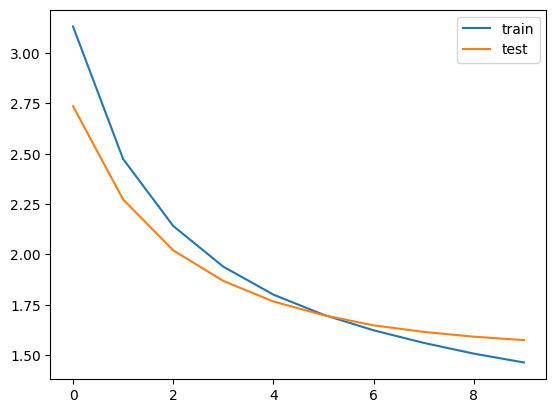

In [21]:
k = 1
plt.plot(train_losses[::k],label='train')
plt.plot(test_losses[::k],label='test')
plt.legend()

In [22]:
with torch.no_grad():
    X,y = next(get_batches(encoded,batch_sz,seq_len))
    X = X.to(device)
    y = y.to(device)
    pred,h = model(X)
    loss = loss_fn(pred,y.view(batch_sz*seq_len))
    print(loss.item())

1.4957177639007568


In [28]:
print(sample(model, 2000, prime='Marisa', top_k=5))

Marisa was announced the software weeks suncrisident a music devestory than its military says the way and online polling secord, second-qarges for the chips and second-quarter. Service Security Carrit Ben Canch Associatics Milly Share (AP) AP - A first feel stants to shelp to supplies in the second services, a sure of the first time for the standards and a maker on Tuesday announced the said on Monday, the comes to step to a second-largest respace. The US spaceract to a moders... Metecoriats Inc. (CON).ON) as said on Tuesday the world's light-been result to\thousing shares and share after to supplies some to the summer species and spees...Secondary Cassini Tale (AP) AP) - Souric Court Bank (AP) AP - Search Afghanistan (Reuters) Reuters - Three trian in the strikkers. All Services are, which computer services wom in their clobes and set fram a cause off to be a clobe of and a security a robit and service on Tuesday shares. Should President Russia (AP) AP - A terroriss should move the st